In [1]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

https://lernapparat.de/debug-device-assert/

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from torch import optim

In [2]:
import sys
sys.path.insert(1, "../../../")

In [9]:
from train import *
from data_preprocessing import *
from evaluation import *
from p_data_augmentation import PowerPIL, Enhanced
import albumentations as A
from Models.yolov8cls_path import Model

In [4]:
if torch.cuda.is_available():
    device=torch.device('cuda')
else:
    device=torch.device('cpu') 

In [5]:
model = Model(num_classes=10, 
              residual_connection=True, 
              CSP=True, 
              add_hidden=True,
              classifyV8=True,
              bottleneck=1.0, 
              variant='s', 
              device=device, 
              dtype=torch.float32)

In [6]:
data_path = '../../../../datasets/imagenette2/'
norms_path = os.path.join(data_path, 'norms.json')

In [7]:
means = get_means(path=norms_path, train_loader=None)
stds = get_stds(path=norms_path, train_loader=None)

Means are: [0.44969913363456726, 0.44868946075439453, 0.45163223147392273]
stds are: [0.28648287057876587, 0.28796446323394775, 0.2865694761276245]


In [8]:
train_dataset = ImageNetSubset(path=data_path, train=True, transform=None, half=False, show=True)

In [9]:
enhanced_transformations = transforms.Compose([transforms.RandomResizedCrop((224, 224)),
                                              PowerPIL(),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean=means, std=stds)])
transformations_val = transforms.Compose([transforms.Resize((224, 224)),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(mean=means, std=stds)
                                                 ])

In [50]:
train_dataset = ImageNetSubset(path=data_path, train=True, transform=enhanced_transformations, half=False, show=False)
val_dataset = ImageNetSubset(path=data_path, train=False, transform=transformations_val, half=False, show=False)

In [51]:
epochs=10
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

In [52]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)

In [53]:
loss_fn = nn.NLLLoss()

In [54]:
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [55]:
lr = 0.01
for i in range(10):
    print(lr)
    lr = lr * 0.9

0.01
0.009000000000000001
0.008100000000000001
0.007290000000000001
0.006561000000000002
0.005904900000000002
0.005314410000000002
0.004782969000000002
0.004304672100000002
0.003874204890000002



Profiling your personal module 
https://pytorch.org/tutorials/beginner/profiler.html

https://discuss.pytorch.org/t/how-to-prevent-overfitting/1902
Right now, with my augmented dataset, at epoch 8, I am getting a testset Top1 accuracy of 45% but a trainset Top1 accuracy of 69%.

You should strongly consider data augmentation in some meaningful way. If you’re attempting to do classification then think about what augmentations might add useful information and help distinguish classes in your dataset. In one of my cases, introducing background variation increased recognition rate by over 50%. Basically, with small datasets there is too much overfitting so you want the network to learn real-world distinctions vs. irrelevant artifacts like backgrounds / shadows etc.

In [39]:
history, gradient_stats = train(epochs, train_loader, val_loader, model, optimizer, loss_fn, scheduler, outputs_path='../../log/YOLOv8cls-version-5/training/')

2024-12-06 22:29:25.539128 Epoch 1 
2024-12-06 22:29:35.799028 Batch 1 
2024-12-06 22:29:36.111959 Batch 2 
2024-12-06 22:29:36.206108 Batch 3 
2024-12-06 22:29:36.284156 Batch 4 
2024-12-06 22:29:36.408918 Batch 5 
2024-12-06 22:29:36.503080 Batch 6 
2024-12-06 22:29:36.594885 Batch 7 
2024-12-06 22:29:36.675135 Batch 8 
2024-12-06 22:29:37.006277 Batch 9 
2024-12-06 22:29:37.096322 Batch 10 
2024-12-06 22:29:37.186381 Batch 11 
2024-12-06 22:29:37.271242 Batch 12 
2024-12-06 22:29:37.612803 Batch 13 
2024-12-06 22:29:37.752597 Batch 14 
2024-12-06 22:29:37.842570 Batch 15 
2024-12-06 22:29:37.939372 Batch 16 
2024-12-06 22:29:38.385303 Batch 17 
2024-12-06 22:29:38.627560 Batch 18 
2024-12-06 22:29:38.712716 Batch 19 
2024-12-06 22:29:38.797408 Batch 20 
2024-12-06 22:29:39.067129 Batch 21 
2024-12-06 22:29:39.387537 Batch 22 
2024-12-06 22:29:39.471369 Batch 23 
2024-12-06 22:29:39.549049 Batch 24 
2024-12-06 22:29:39.711570 Batch 25 
2024-12-06 22:29:40.025319 Batch 26 
2024-12-06 

In [40]:
history, gradient_stats = train(epochs, train_loader, val_loader, model, optimizer, loss_fn, scheduler, outputs_path='../../log/YOLOv8cls-version-5/training/', resume=True)

C:\Me\PJAIT\Thesis\Code\yolov2-to-yolov8\Backbone experiments\YOLOv8s-cls Path\Version 5\../../..\train.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.lo

2024-12-06 22:42:38.475547 Epoch 11 
2024-12-06 22:42:48.640997 Batch 1 
2024-12-06 22:42:48.912131 Batch 2 
2024-12-06 22:42:49.005787 Batch 3 
2024-12-06 22:42:49.084301 Batch 4 
2024-12-06 22:42:49.278406 Batch 5 
2024-12-06 22:42:49.362332 Batch 6 
2024-12-06 22:42:49.441882 Batch 7 
2024-12-06 22:42:49.528581 Batch 8 
2024-12-06 22:42:49.892341 Batch 9 
2024-12-06 22:42:49.982384 Batch 10 
2024-12-06 22:42:50.062397 Batch 11 
2024-12-06 22:42:50.153292 Batch 12 
2024-12-06 22:42:50.478877 Batch 13 
2024-12-06 22:42:50.568887 Batch 14 
2024-12-06 22:42:50.648928 Batch 15 
2024-12-06 22:42:50.742361 Batch 16 
2024-12-06 22:42:51.087724 Batch 17 
2024-12-06 22:42:51.177759 Batch 18 
2024-12-06 22:42:51.267776 Batch 19 
2024-12-06 22:42:51.359802 Batch 20 
2024-12-06 22:42:51.720073 Batch 21 
2024-12-06 22:42:51.810109 Batch 22 
2024-12-06 22:42:51.890154 Batch 23 
2024-12-06 22:42:51.987608 Batch 24 
2024-12-06 22:42:52.316350 Batch 25 
2024-12-06 22:42:52.406216 Batch 26 
2024-12-06

In [16]:
my_transformations = transforms.Compose([transforms.RandomResizedCrop((224, 224)),
                                              Enhanced(),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean=means, std=stds)])
transformations_val = transforms.Compose([transforms.Resize((224, 224)),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(mean=means, std=stds)
                                                 ])

In [17]:
train_dataset = ImageNetSubset(path=data_path, train=True, transform=my_transformations, half=False, show=False)
val_dataset = ImageNetSubset(path=data_path, train=False, transform=transformations_val, half=False, show=False)

In [18]:
epochs=10
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=1)

In [19]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)

In [20]:
loss_fn = nn.NLLLoss()

In [21]:
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

<module 'matplotlib.pyplot' from 'C:\\Vstanovlene\\Anaconda Distribution\\envs\\new_gpu_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

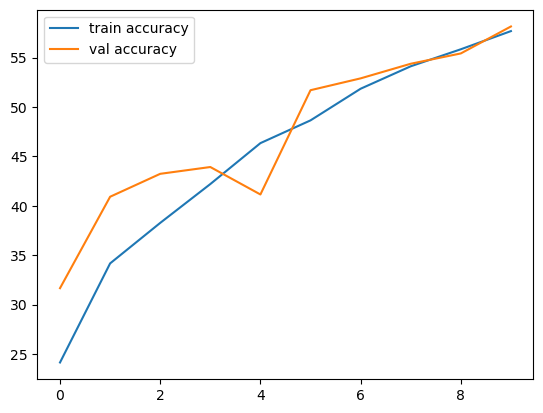

In [25]:
history = load_train_outputs('../../log/YOLOv8cls-version-5/training/')['history']
plot_accuracy(history)

In [26]:
history, gradient_stats = train(epochs, train_loader, val_loader, model, optimizer, loss_fn, scheduler, outputs_path='../../log/YOLOv8cls-version-5/training/')

2024-12-07 13:10:20.914283 Epoch 1 
2024-12-07 13:10:30.001605 Batch 15 
2024-12-07 13:10:35.990918 Batch 30 
2024-12-07 13:10:42.334023 Batch 45 
2024-12-07 13:10:48.597103 Batch 60 
2024-12-07 13:10:55.066174 Batch 75 
2024-12-07 13:11:01.568677 Batch 90 
2024-12-07 13:11:07.970955 Batch 105 
2024-12-07 13:11:15.040434 Batch 120 


KeyboardInterrupt: 

In [18]:
history, gradient_stats = train(epochs, train_loader, val_loader, model, 
                                optimizer, loss_fn, scheduler, 
                                outputs_path='../../log/YOLOv8cls-version-5/training/', 
                                resume=True)

C:\Me\PJAIT\Thesis\Code\yolov2-to-yolov8\Backbone experiments\YOLOv8s-cls Path\Version 5\../../..\train.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.lo

2024-12-07 12:48:50.283284 Epoch 11 
2024-12-07 12:48:53.440848 Batch 1 
2024-12-07 12:48:53.852769 Batch 2 
2024-12-07 12:48:54.261346 Batch 3 
2024-12-07 12:48:54.676042 Batch 4 
2024-12-07 12:48:55.230437 Batch 5 
2024-12-07 12:48:55.637605 Batch 6 
2024-12-07 12:48:56.060935 Batch 7 
2024-12-07 12:48:56.488071 Batch 8 
2024-12-07 12:48:56.885850 Batch 9 
2024-12-07 12:48:57.423212 Batch 10 
2024-12-07 12:48:57.833594 Batch 11 
2024-12-07 12:48:58.240806 Batch 12 
2024-12-07 12:48:58.650967 Batch 13 
2024-12-07 12:48:59.068429 Batch 14 
2024-12-07 12:48:59.495345 Batch 15 
2024-12-07 12:48:59.946089 Batch 16 
2024-12-07 12:49:00.385926 Batch 17 
2024-12-07 12:49:00.773448 Batch 18 
2024-12-07 12:49:01.170290 Batch 19 
2024-12-07 12:49:01.607482 Batch 20 
2024-12-07 12:49:02.091718 Batch 21 
2024-12-07 12:49:02.586541 Batch 22 
2024-12-07 12:49:03.049719 Batch 23 
2024-12-07 12:49:03.507354 Batch 24 
2024-12-07 12:49:03.934149 Batch 25 
2024-12-07 12:49:04.360085 Batch 26 
2024-12-07

KeyboardInterrupt: 